- Minecraft Version 1.21.5
- Seed: "vcpi"
- Gamerules: "doDaylightCycle=false" "doWeatherCycle=false" "doMobSpawning=false"
- Commands. /time set day
- render distance: 12

In [1]:
import os
import time

from tqdm import tqdm
from pathlib import Path
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms

from src.dataset import PairedImageDataset

cuda = torch.cuda.is_available()

device = torch.device("cuda" if cuda else "cpu")
print(f"Using device: {device}")

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Using device: cuda


In [2]:
BATCH_SIZE = 4

transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_ds = PairedImageDataset("generator_bot/screenshots", transforms=transform)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)

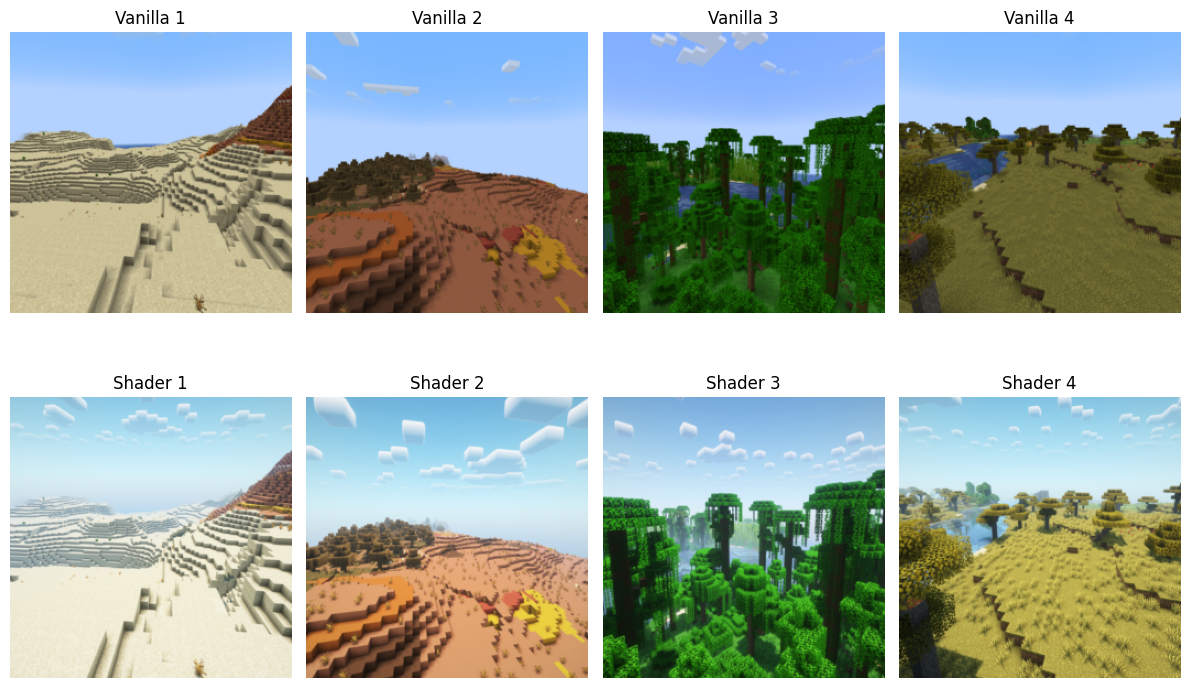

In [3]:
# Show some pairs of images using pyplot
plt.figure(figsize=(12, 8))

# Get a batch of data
batch = next(iter(train_dl))

vanilla_images = batch["vanilla"]
shader_images = batch["shader"]


def denormalize(tensor):
    return (tensor + 1.0) / 2.0


# Display pairs of images
for i in range(min(4, vanilla_images.size(0))):
    # Vanilla image
    plt.subplot(2, 4, i + 1)
    vanilla_img = denormalize(vanilla_images[i]).permute(1, 2, 0)
    plt.imshow(vanilla_img.cpu().numpy())
    plt.title(f"Vanilla {i + 1}")
    plt.axis("off")

    # Shader image
    plt.subplot(2, 4, i + 5)
    shader_img = denormalize(shader_images[i]).permute(1, 2, 0)
    plt.imshow(shader_img.cpu().numpy())
    plt.title(f"Shader {i + 1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [4]:
from src.generator import GeneratorUNet
from src.discriminator import PatchDiscriminator

G = GeneratorUNet().to(device)
D = PatchDiscriminator().to(device)

g_opt = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_opt = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

gan_criterion = nn.BCEWithLogitsLoss()
l1_criterion = nn.L1Loss()

In [5]:
def train_epoch(dataloader, G, D, g_opt, d_opt, gan_crit, l1_crit, lambda_l1=100):
    G.train()
    D.train()

    total_discriminator_loss = 0
    total_generator_loss = 0
    total_gan_loss = 0
    total_l1_loss = 0
    total_real_loss = 0
    total_fake_loss = 0

    num_batches = 0

    loop = tqdm(dataloader, leave=True, unit_scale=BATCH_SIZE, unit="pairs")

    for idx, batch in enumerate(loop):
        x = batch["vanilla"].to(device, non_blocking=True)
        y = batch["shader"].to(device, non_blocking=True)

        valid = torch.ones((x.size(0), 1, 16, 16), device=device)
        fake = torch.zeros_like(valid)

        # ---- Discriminator ----
        d_opt.zero_grad()
        # Real
        real_pred = D(x, y)
        d_real_loss = gan_crit(real_pred, valid)
        # Fake
        y_fake = G(x)
        fake_pred = D(x, y_fake.detach())
        d_fake_loss = gan_crit(fake_pred, fake)
        d_loss = (d_real_loss + d_fake_loss) * 0.5
        d_loss.backward()
        d_opt.step()

        # ---- Generator ----
        g_opt.zero_grad()
        # GAN loss
        fake_pred = D(x, y_fake)
        g_gan = gan_crit(fake_pred, valid)
        # Reconstruction loss
        g_l1 = l1_crit(y_fake, y) * lambda_l1
        g_loss = g_gan + g_l1
        g_loss.backward()
        g_opt.step()

        total_discriminator_loss += d_loss.item()
        total_generator_loss += g_loss.item()
        total_gan_loss += g_gan.item()
        total_l1_loss += g_l1.item()
        total_real_loss += d_real_loss.item()
        total_fake_loss += d_fake_loss.item()
        num_batches += 1

        loop.set_postfix(
            d_loss=total_discriminator_loss / (idx + 1),
            d_real_loss=total_real_loss / (idx + 1),
            d_fake_loss=total_fake_loss / (idx + 1),
            g_loss=total_generator_loss / (idx + 1),
            g_gan=total_gan_loss / (idx + 1),
            g_l1=total_l1_loss / (idx + 1),
        )

    return {
        "discriminator_loss": total_discriminator_loss / num_batches,
        "generator_loss": total_generator_loss / num_batches,
        "gan_loss": total_gan_loss / num_batches,
        "l1_loss": total_l1_loss / num_batches,
        "real_loss": total_real_loss / num_batches,
        "fake_loss": total_fake_loss / num_batches,
    }

In [6]:
prev_time = time.time()

EPOCHS = 5

for epoch in range(0, EPOCHS):
    train_epoch(train_dl, G, D, g_opt, d_opt, gan_criterion, l1_criterion)

100%|██████████| 1304/1304 [00:40<00:00, 32.45img/s, d_fake_loss=0.492, d_loss=0.507, d_real_loss=0.521, g_gan=1.48, g_l1=9.45, g_loss=10.9]


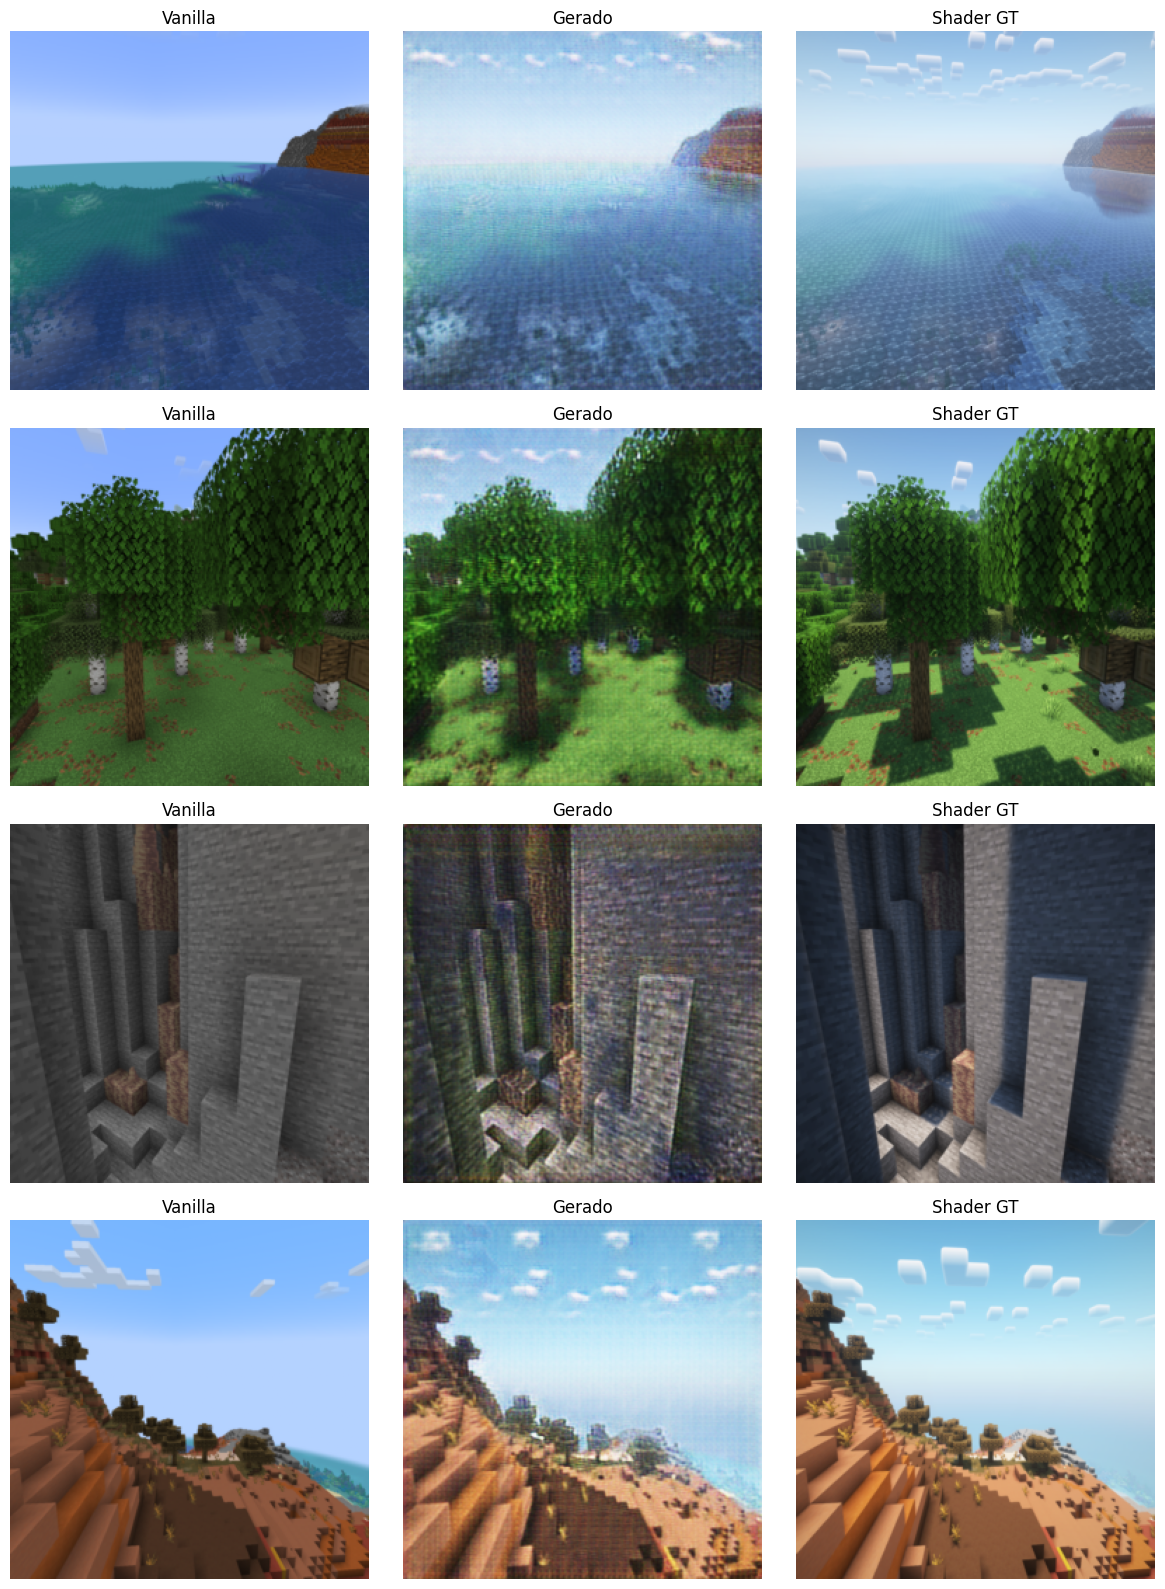

In [7]:
def show_results(x, y, y_hat, n=4):
    x = (x + 1) / 2
    y = (y + 1) / 2
    y_hat = (y_hat + 1) / 2
    fig, axes = plt.subplots(n, 3, figsize=(12, 4 * n))
    for i in range(n):
        axes[i, 0].imshow(x[i].permute(1, 2, 0).cpu())
        axes[i, 0].set_title("Vanilla")
        axes[i, 1].imshow(y_hat[i].permute(1, 2, 0).cpu())
        axes[i, 1].set_title("Generated")
        axes[i, 2].imshow(y[i].permute(1, 2, 0).cpu())
        axes[i, 2].set_title("Shader")
        for ax in axes[i]:
            ax.axis("off")
    plt.tight_layout()
    plt.show()


batch = next(iter(train_dl))
x, y = batch["vanilla"].to(device), batch["shader"].to(device)
with torch.no_grad():
    y_hat = G(x)
show_results(x, y, y_hat)